# Network graphing and clustering
Probably one of the most complicated modules in my code, so I hope to explain it further below. The idea is to create a correlation network of S&P500 stocks. Maybe we need to explain a bit about correlations first before we get to the complicated part.

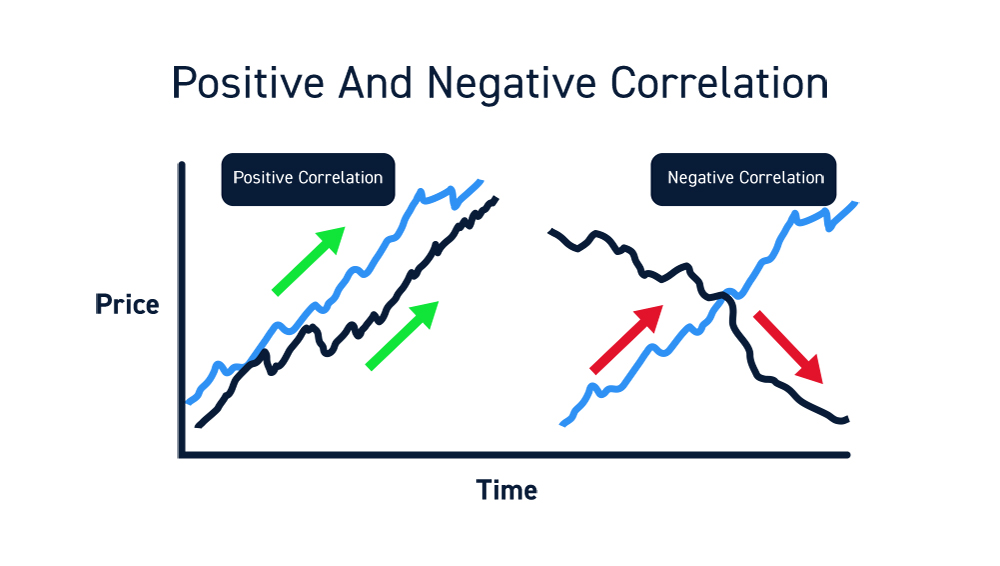

Correlations(calculated by df.corr()) basically display how similar two stocks behave to eachother. Do they react to certain events similarly? Or maybe one profits where the other drops? A high correlation (0.7+) usually means, the two stocks move similarly but not the exact same. So: a stock has a correlation of 1 with itself, that means: perfect alignment.
### But why do we need that? 
There are multiple perks of looking at correlations, trust me. For example:
- How does a crisis affect an entire market(all companies or certain industries)
- How intertwined are certain industries and how central are the market movement of some companies for others?

I really like browsing through historical networking graphs, let us take a look at some examples of how to interpret these:

### Example one: Q2 2020
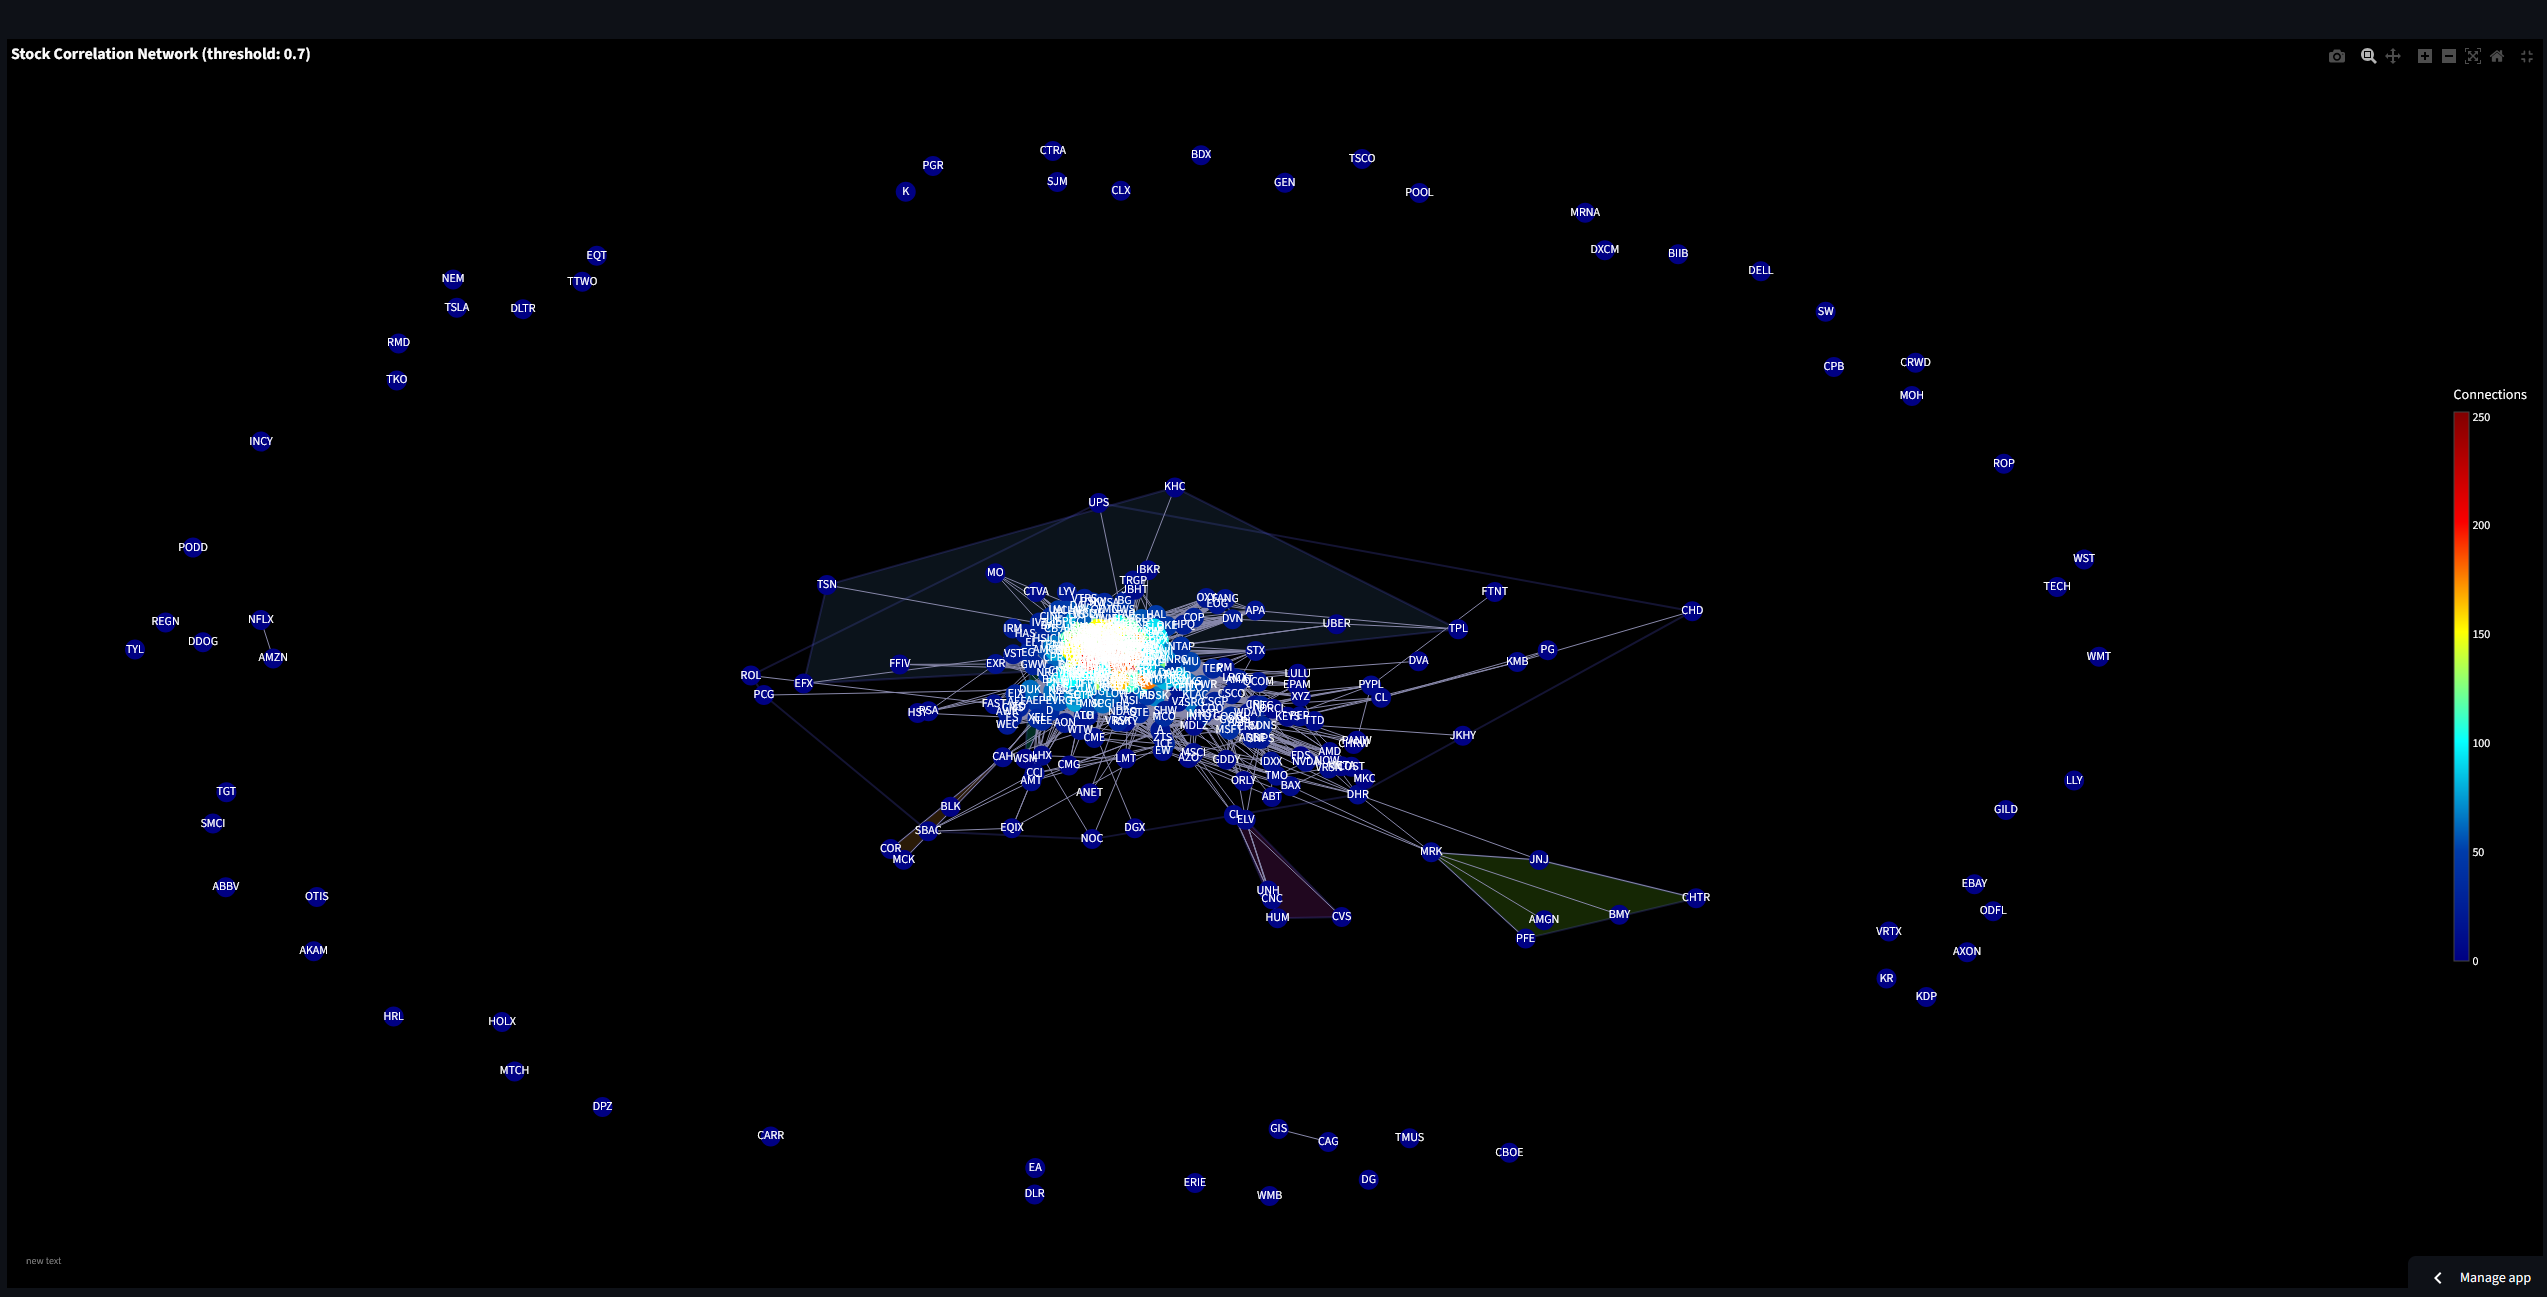 <br>

What looks like an unbelievable mess is actually something very interesting for analytics: We expect at most 50 connections in regular quarters but here we see up to 250. But why? 
Q2 of 2020 was during the height of covid in, the market crashed and this impacted (almost) every company. If all stocks go down, we expect the correlations to be high(postive), whereas some companies seem unfazed by this movement. For example: Netflix, Amazon, Ebay, Electronic Arts, etc. Companies that profited from lockdown rather than suffered from it. 


### Example two: Q2 2022
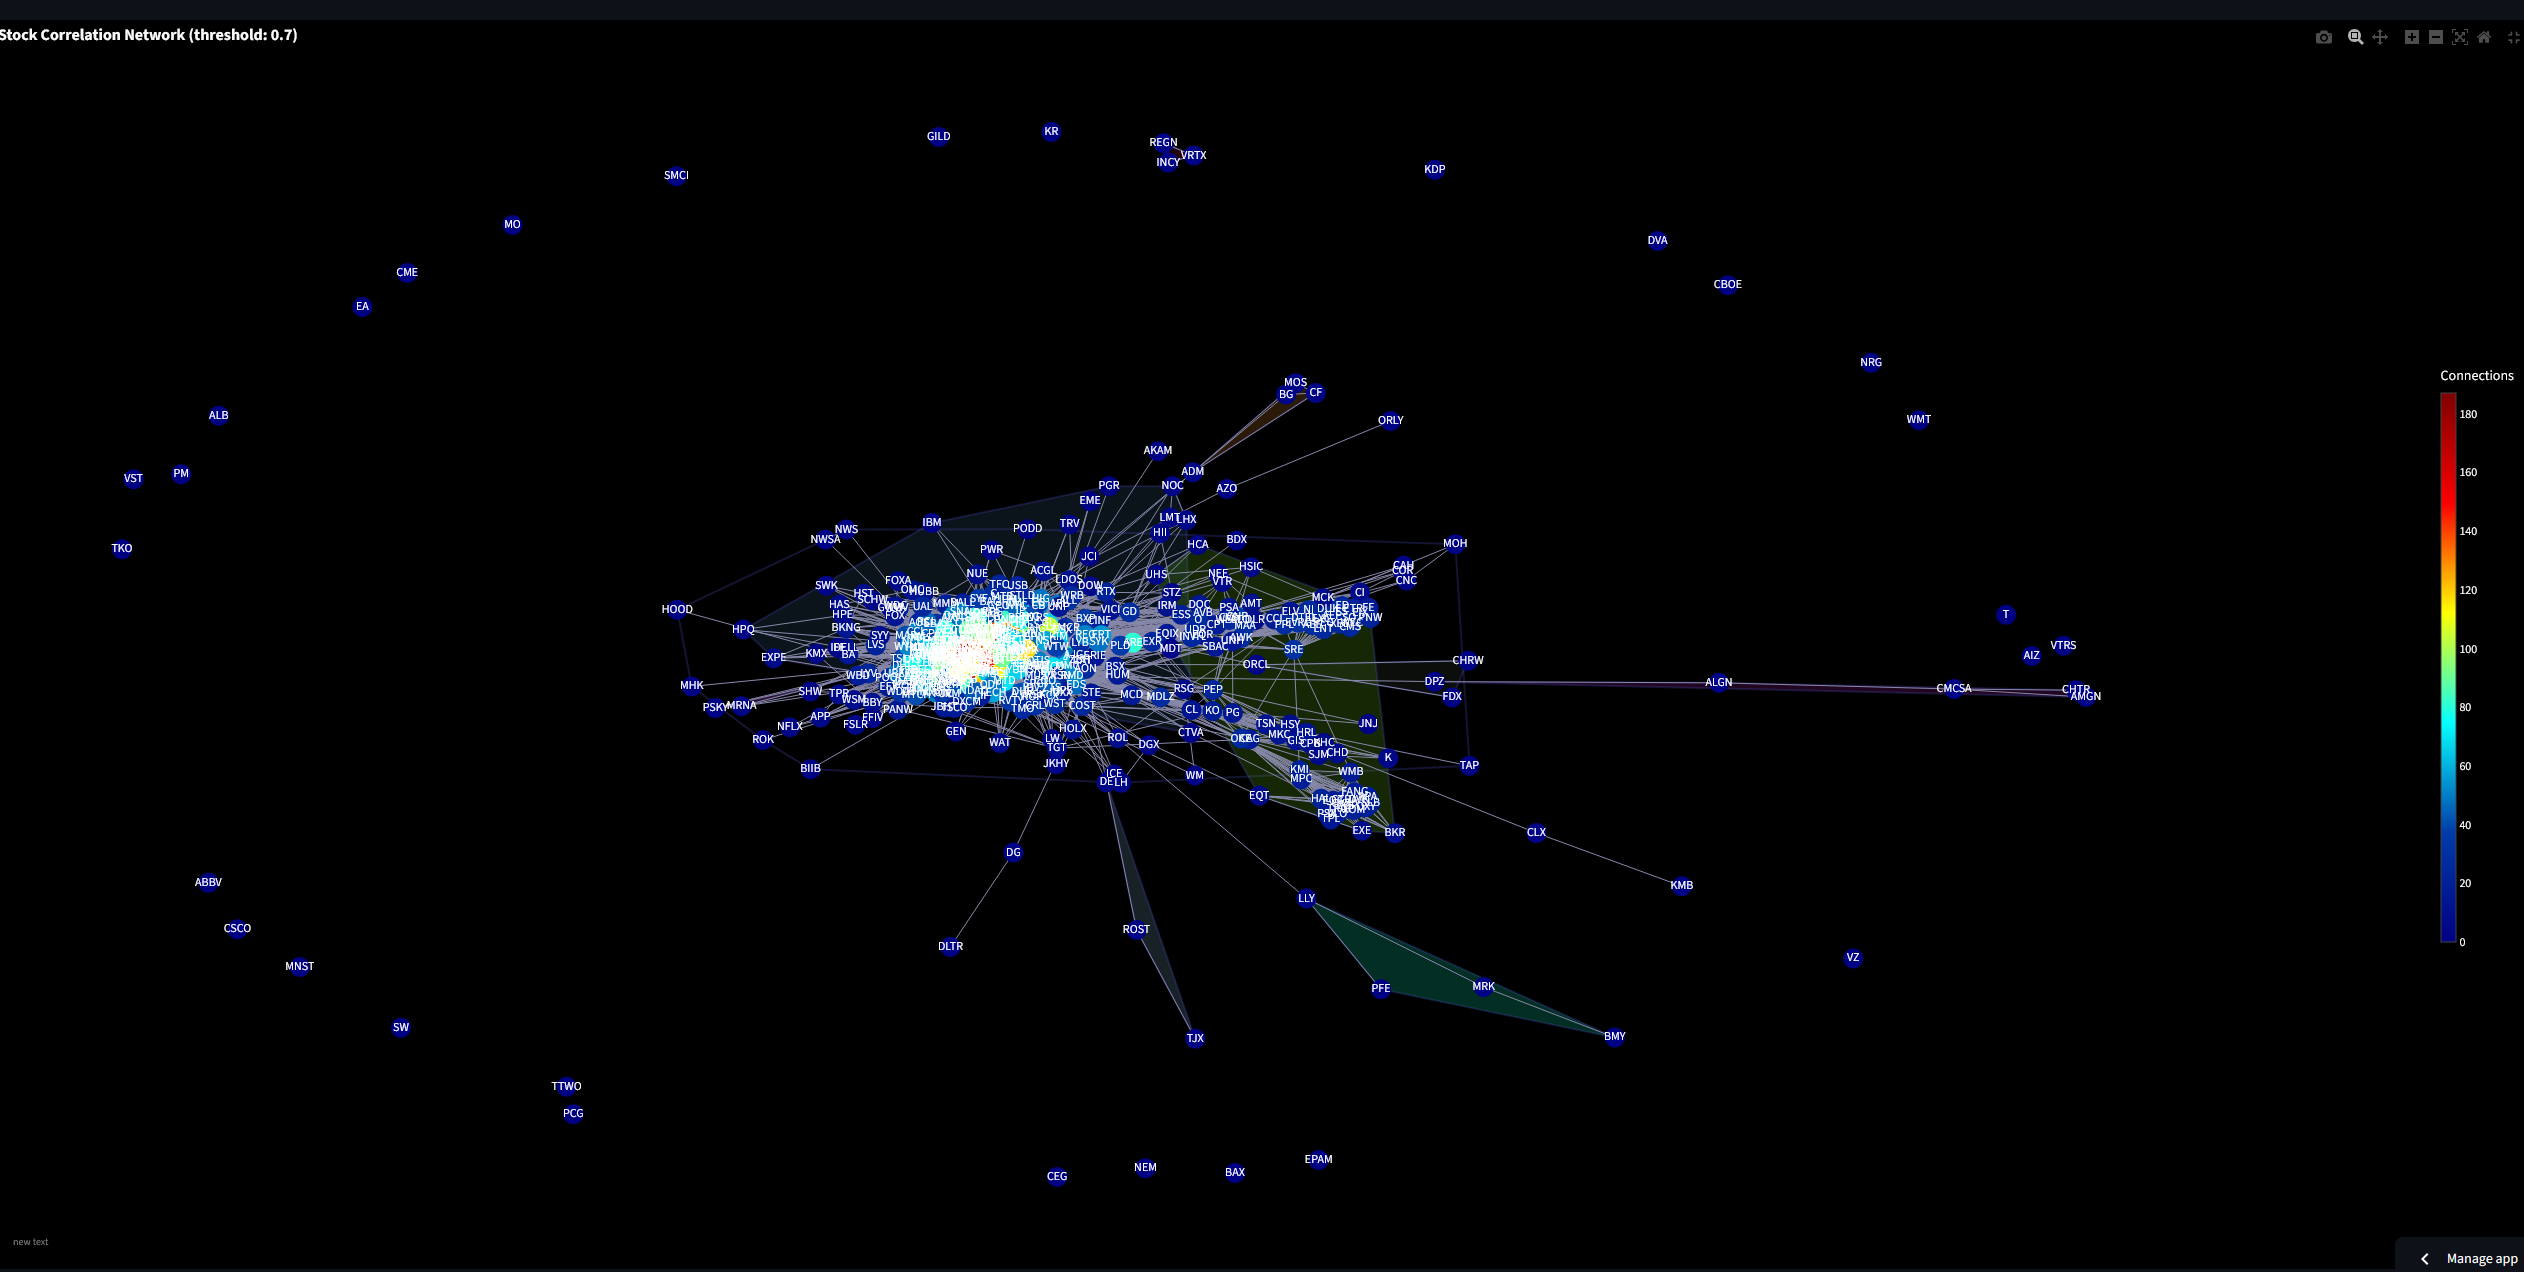 <br>

Similar situation than Covid: Now we're talking about the start of the Ukraine war. Also a clear indicator that fear can also reach the stock market and affect analytics.

### Example 3: Most current graph (Nov 2025)
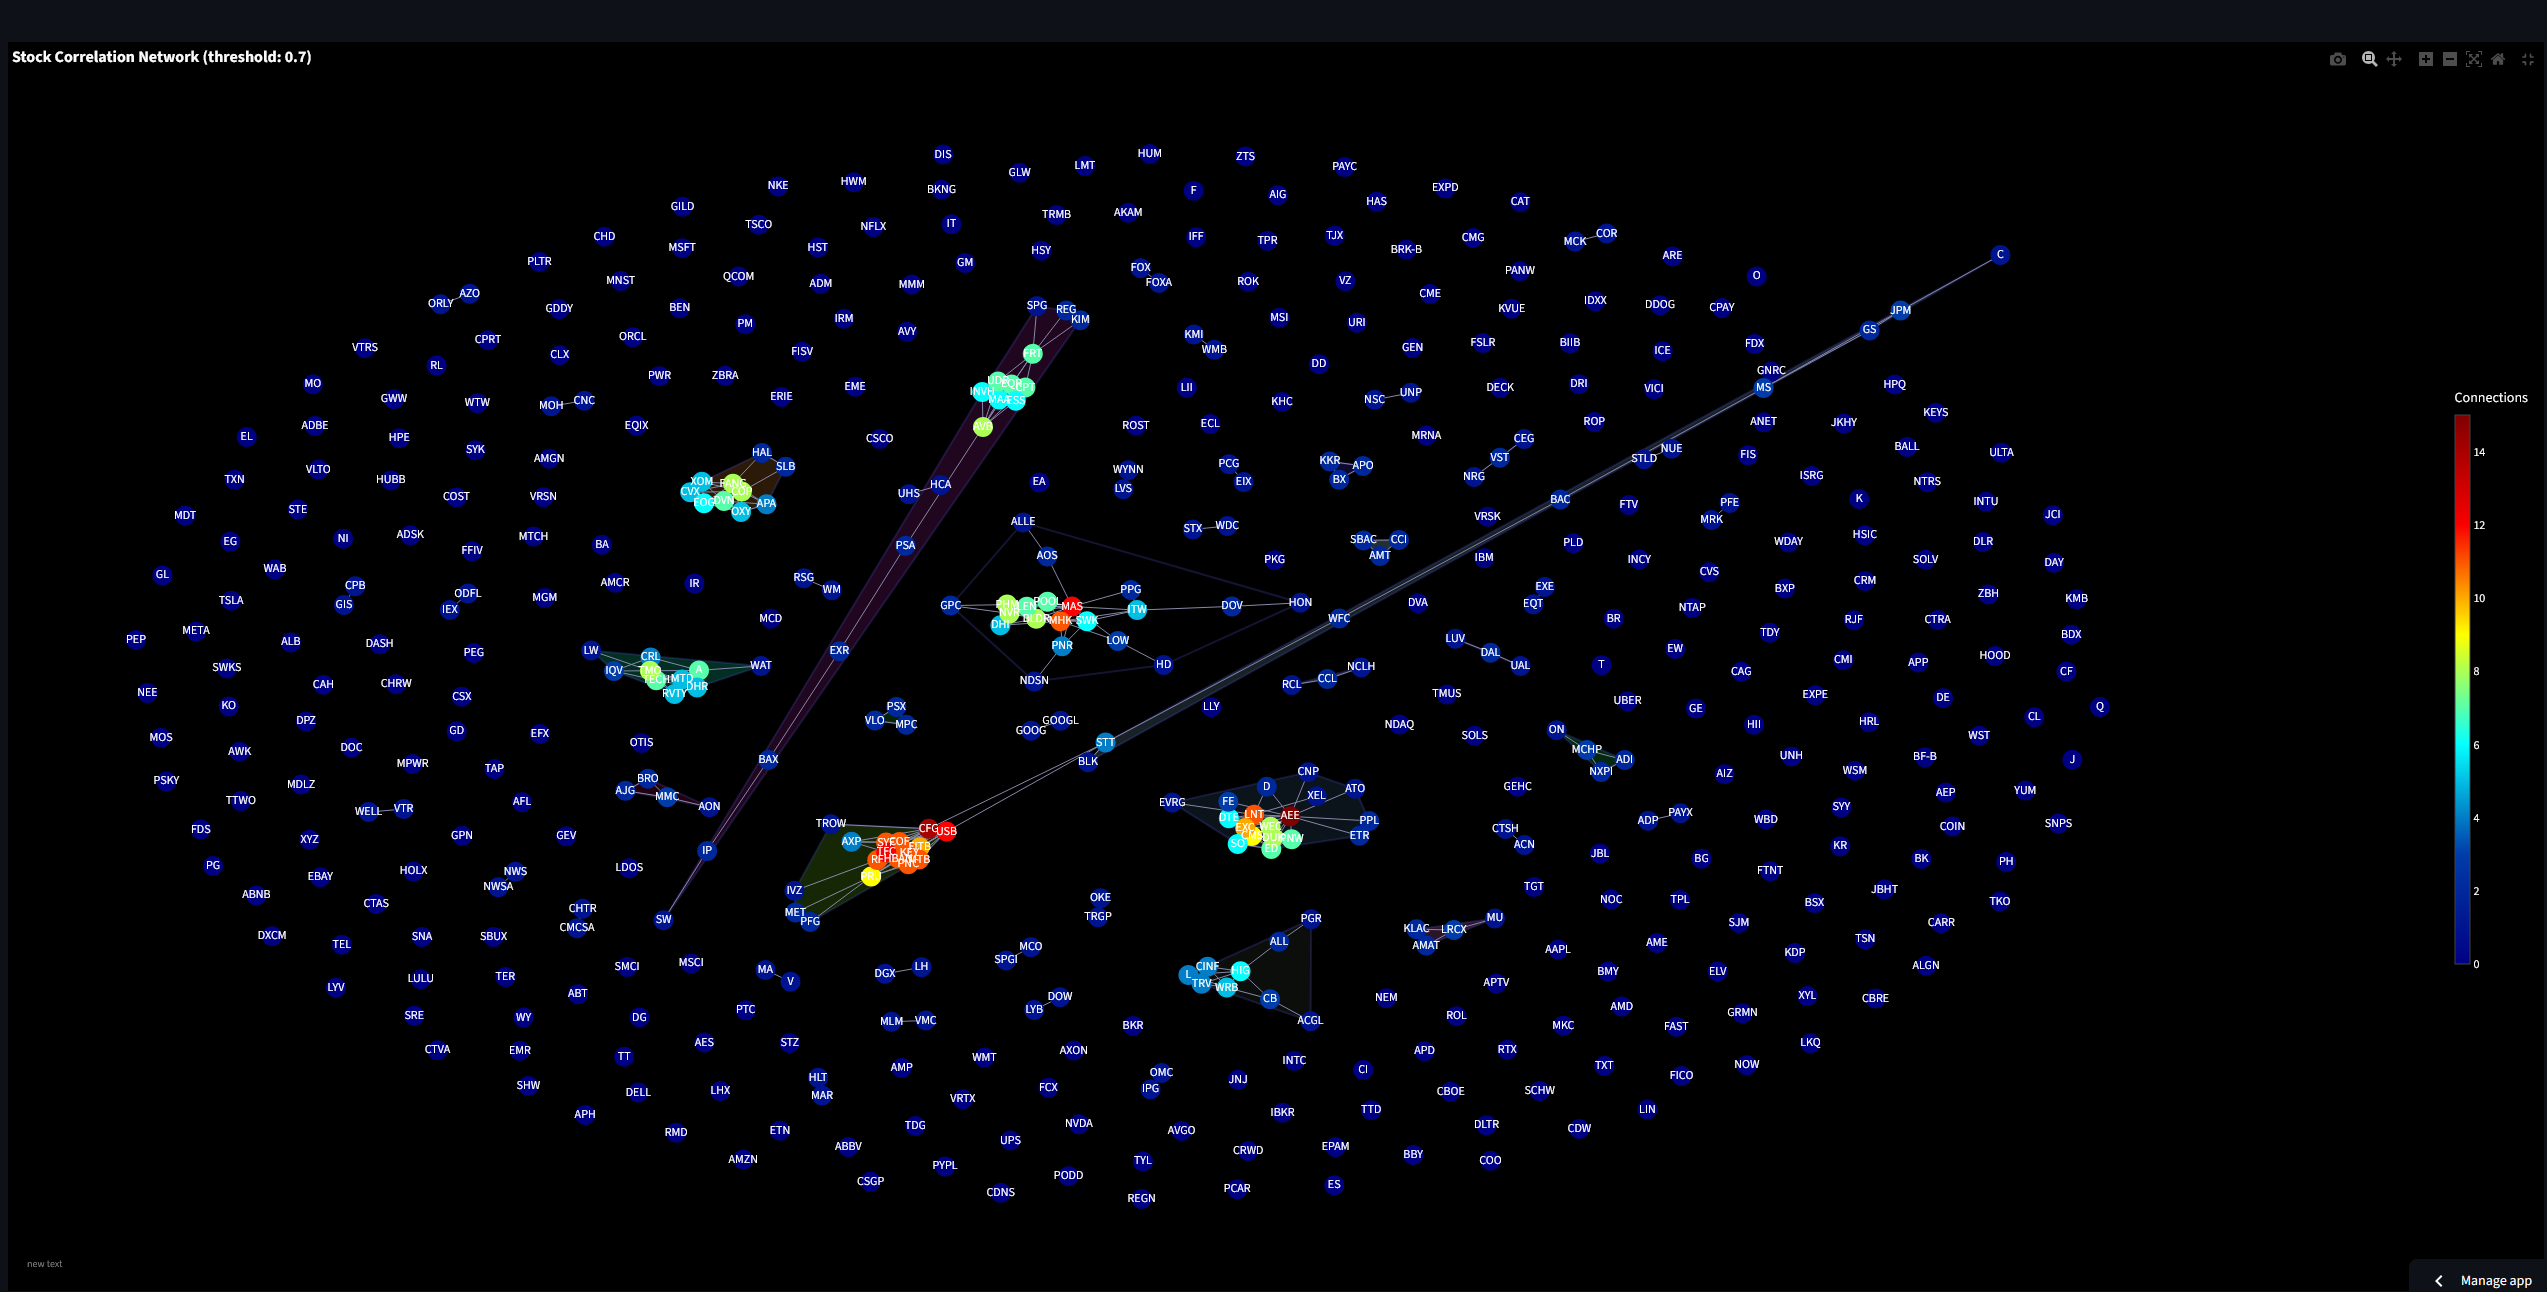<br>

Just for reference: That is how you expect a normal network graph with a high threshold should look like. You can clearly see clusters of industries which seem to be very intertwined.
But now to the exciting part: How did I do that?


# Imports


In [ ]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import urllib.request

# suggestion by ChatGPT in a brainstorming session
from networkx.algorithms import community as nx_comm
from scipy.spatial import ConvexHull
import plotly.io as pio

# Creating a network
First, we need a network:
- Step one: Create a graph G
- Step two: Add nodes from the correlation dataframe
- Step three: Add edges(connections) between nodes by checking whether the correlation is higher than the threshold
- Step four: Return G in order to plot it later

In [ ]:
def create_network(df_correlation, threshold):
    '''Creates a network graph out of a correlation matrix'''

    G = nx.Graph()

    # add nodes to G
    nodes = df_correlation.index.to_list()

    G.add_nodes_from(nodes)

    # add edges based on threshold
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            corr_value = df_correlation.iloc[i, j]
            if abs(corr_value) >= threshold:
                G.add_edge(nodes[i], nodes[j], weight=corr_value)

    return G

# Plotting the network
Now that we have a graph we need to plot it(arguably more difficult :C).
We take G from the create_network function, apply a dark theme (more pleasant for the eyes) and create lists for edges(coordinates, info and colors). Afterwards we decided on a spring layout. The spring layout is a visualization algorithm that uses physics to position nodes. Ref: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html.
As method we use energy, it places the most connections into the center, while force alligns all of them in a circle (nightmare for clustering). 

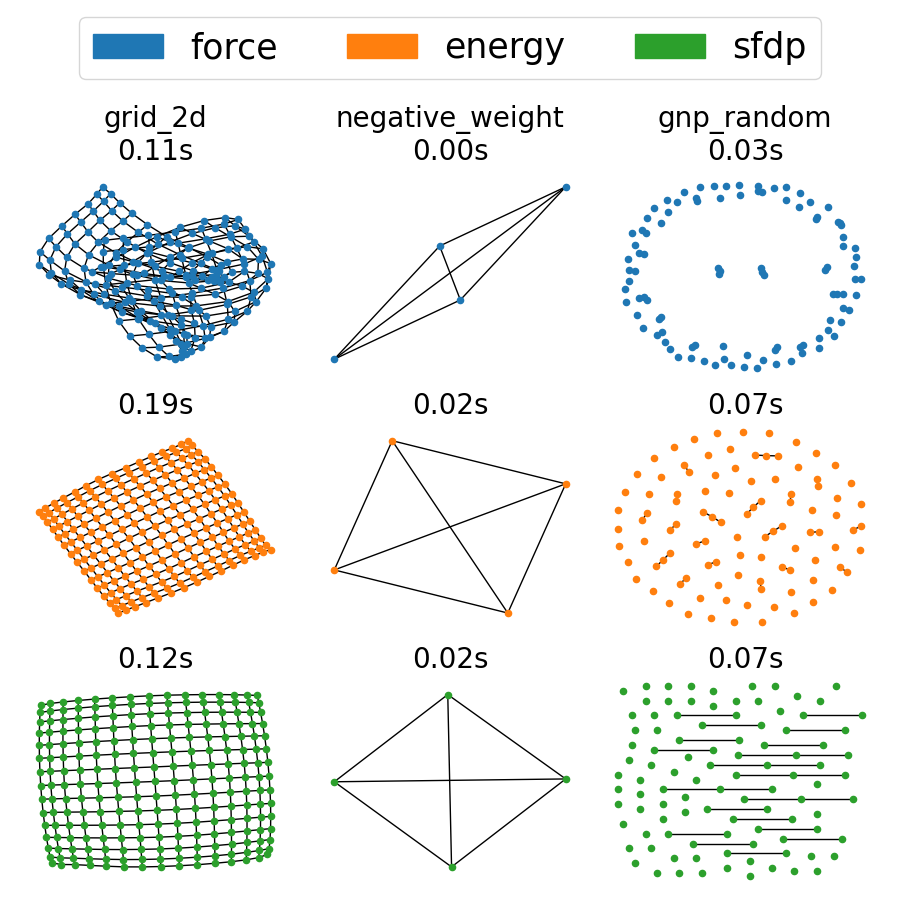 <br>

Afterwards we append the lists with data from the edges and create lists for nodes and append data from them too. I also recently added more company info, which can be fetched from the wikipedia html. For the nodes we mainly need the hover text data (avg corr, company info etc).

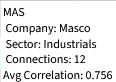

Now we create the graph object figure via plotly: https://plotly.com/python/graph-objects/

We add all our edges and nodes as traces and update the layout to make it look prettier and more enjoyable to watch/interact with. 

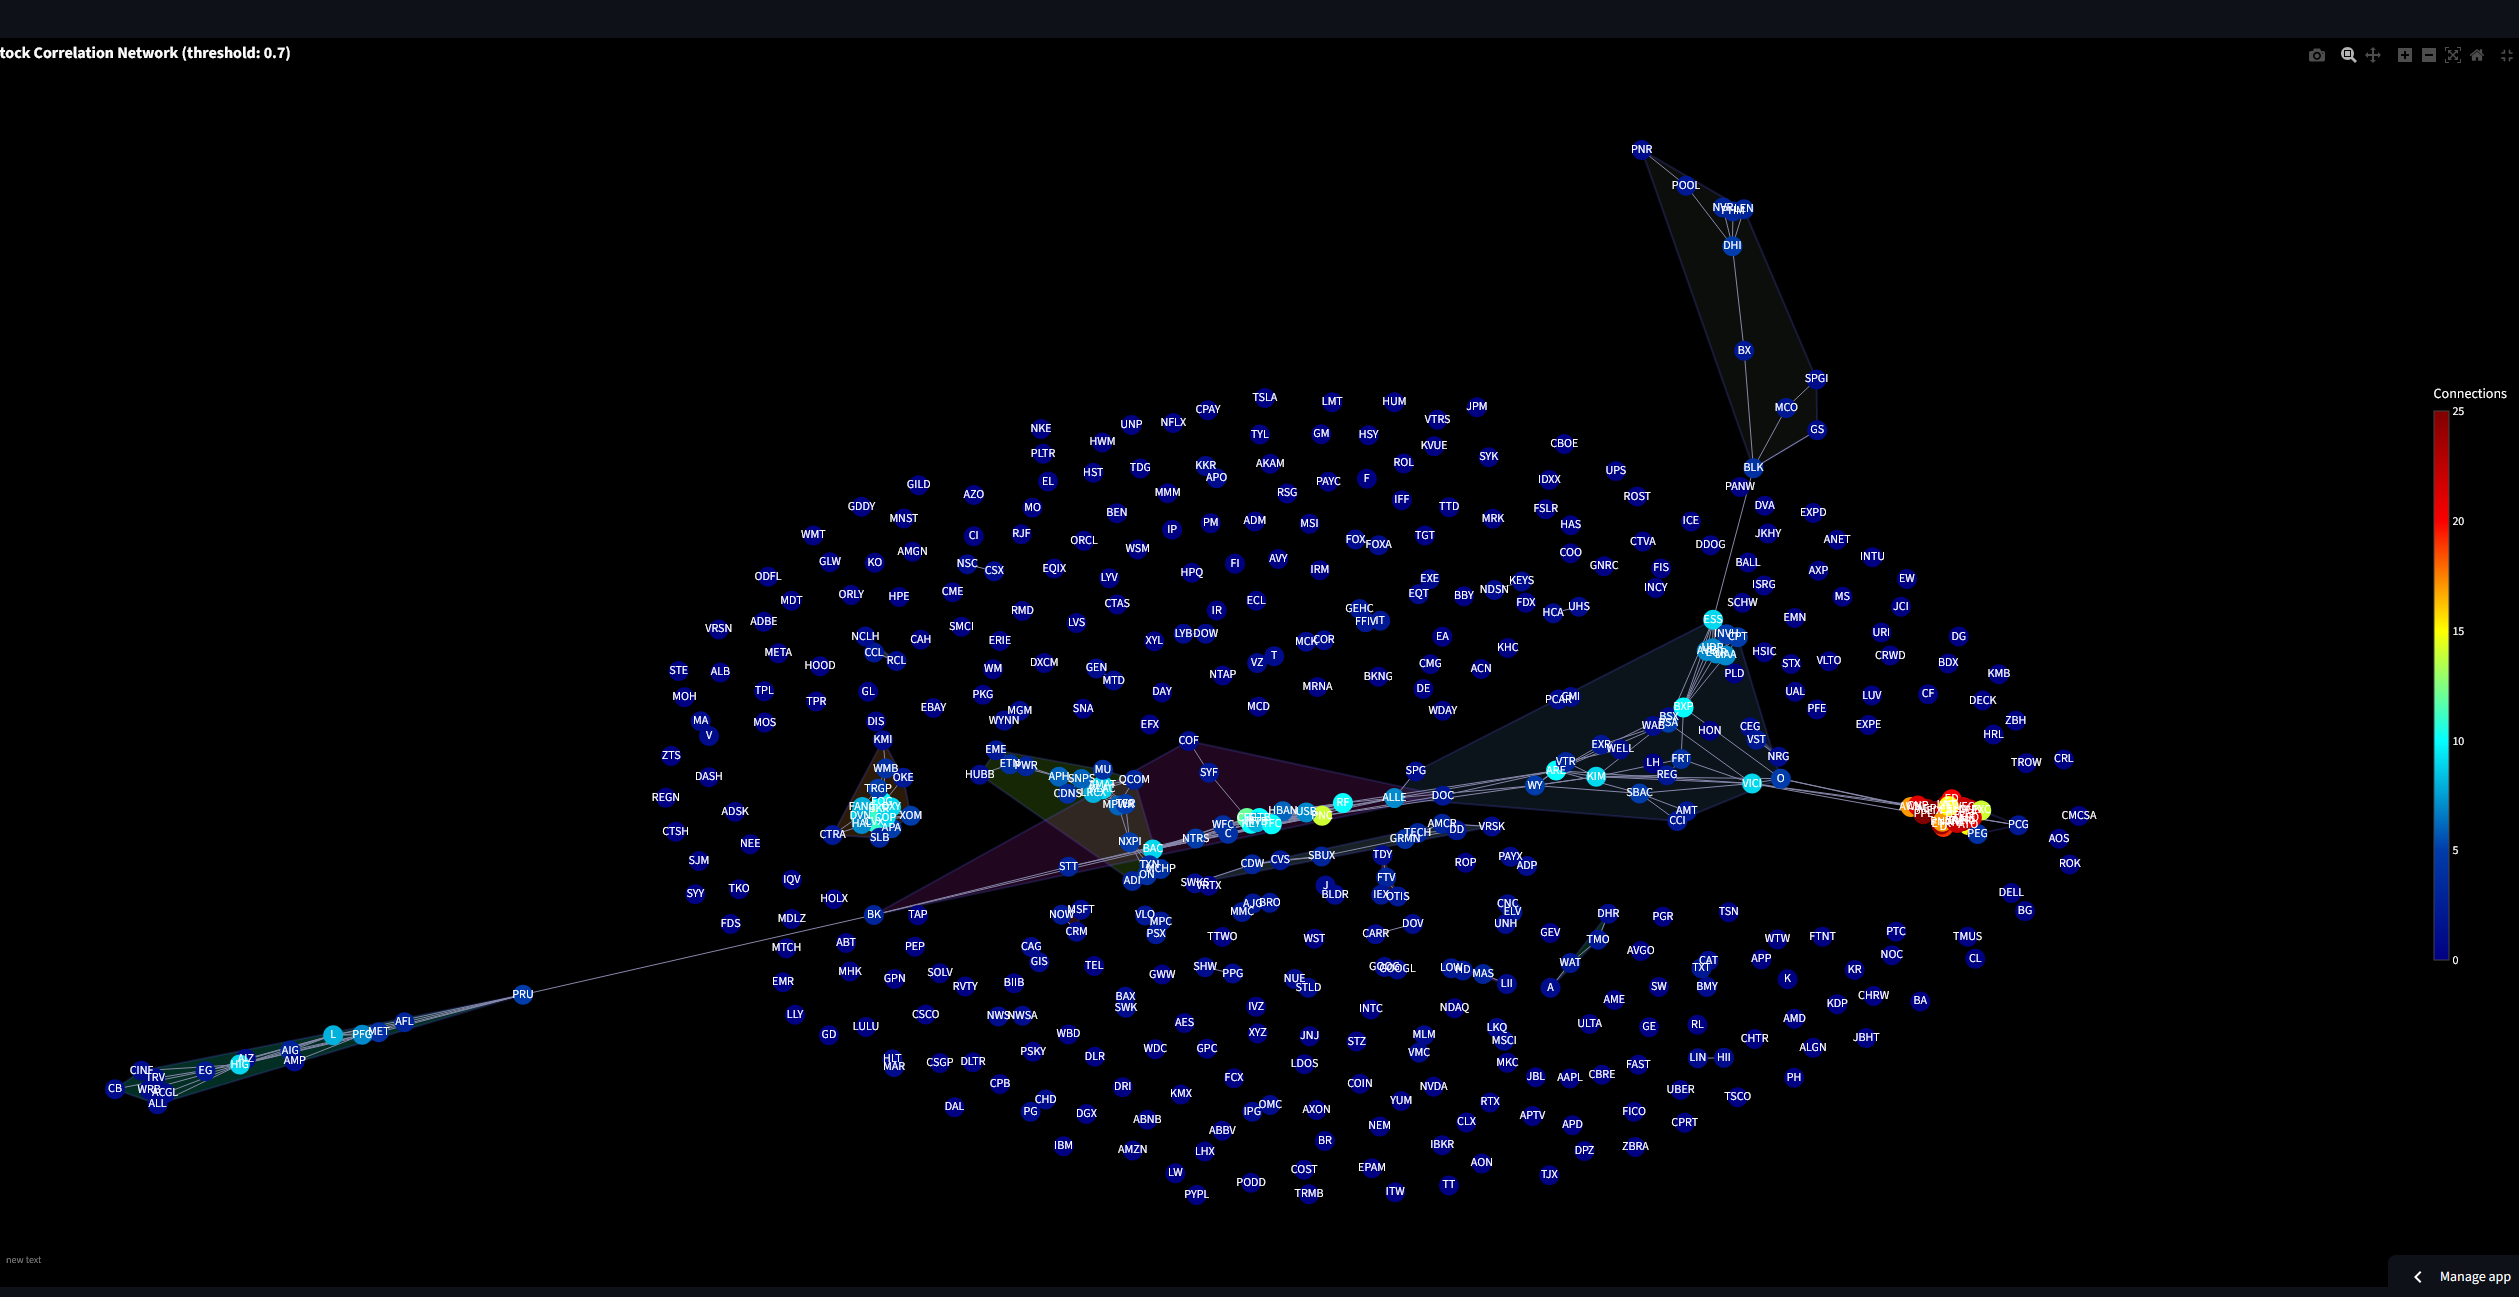

You might've noticed we skipped clustering: But it's next on our list.

In [ ]:
def plot_network(df_correlation, threshold):
    '''Plots the graph with plotly'''

    G = create_network(df_correlation, threshold)

    pio.templates.default = "plotly_dark"

    # use spring layout, most meaningful
    pos = nx.spring_layout(G, seed=42, k=6, method="energy")

    # create lists for edges
    edge_x = []
    edge_y = []
    edge_info = []
    edge_colors = []

    # append the lists with data from the edges
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

        weight = G[edge[0]][edge[1]]['weight']
        edge_info.append(f'{edge[0]} - {edge[1]}: {weight:.3f}')

        if weight > 0:
            edge_colors.extend(['green', 'green', None])
        else:
            edge_colors.extend(['red', 'red', None])

    # create lists for nodes
    node_x = []
    node_y = []
    node_text = []
    node_colors = []

    company_info = get_company_info()

    # aoppend with data from teh nodes
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # get adjacencies and average correlation
        adjacencies = list(G.neighbors(node))
        node_info = f'{node}<br> Company: {company_info.get(node, {}).get("name", "N/A")} <br> Sector: {company_info.get(node, {}).get("sector", "N/A")} <br> Connections: {len(adjacencies)}'
        if len(adjacencies) > 0:
            correlations = [G[node][adj]['weight'] for adj in adjacencies]
            avg_corr = np.nanmean(correlations) if len(correlations) else 0.0
            node_info += f'<br>Avg Correlation: {avg_corr:.3f}'

        node_text.append(node_info)

        # change colours based on amount of adjacencies(not yet implemented)
        node_colors.append(len(adjacencies))

    # create plotly figure
    fig = go.Figure()
    clustering(G, pos, fig)

    # add edges with data
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#8888aa'),
        hoverinfo='none',
        mode='lines',
        name='Connections'))

    # add nodes with data
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=list(G.nodes()),
        hovertext=node_text,
        textposition="middle center",
        marker=dict(
            showscale=True,
            colorscale='jet',
            color=node_colors,
            size=20,
            colorbar=dict(
                thickness=15,
                len=0.5,
                x=1.1,
                title="Connections"),
        ),
        name='Stocks'))

    # created with the help of claude since I usually never use plotly, also very tiring/boring to do all of it by myself
    fig.update_layout(
        title=dict(
            text=f'Stock Correlation Network (threshold: {threshold})',
            font=dict(size=16)),
        autosize=True,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        annotations=[dict(
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002,
            xanchor='left', yanchor='bottom',
            font=dict(color='gray', size=10))],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='black',
        paper_bgcolor='black',
        font_color='white',
        hoverlabel=dict(
            bgcolor="white",
            font_color="black"))

    return fig

# Clustering
To see clusters in our graph (perfect for analysis) we need some sort of clustering setup: The degrees of my plot made louvain very painful to work with, so I opted for greedy modularity. "Greedy modularity maximization begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no further increase in modularity is possible (a maximum)." 
In easy terms: It always takes the best available connection until none are available anymore.

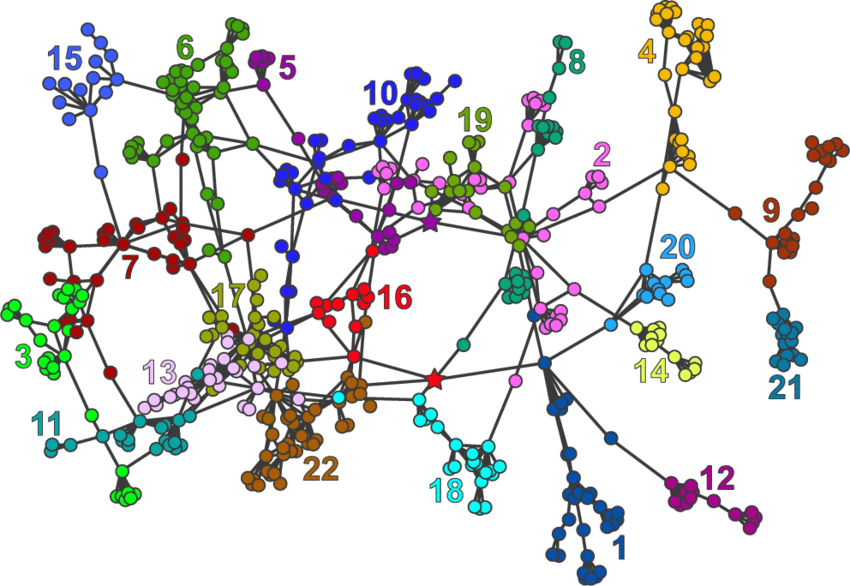

Luckily networkx also offers greedy modularity modules, so it's pretty straightforward

- Step one: remove isolated nodes: Increase speed because amount of nodes to be checked are halved or more
- Step two: create communities with nx_comm.greedy_modularity_communities of the cleaned graph
- Step three: Partition the nodes and group them
- Step four: Create a convec hull and shape if there are more than 3 nodes with random colours
- Step five: Add the shape to the figure

In [ ]:
def clustering(G, pos, fig):
    '''Cluster the data'''

    # remove non-existing nodes and partition the existing ones (otherwise nx will literally scream at you in agony)
    # replaced louvain with greedy modularity because louvain failed consistently (do not ask me why, I went through enough)
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html
    G_clean = G.copy()
    G_clean.remove_nodes_from(list(nx.isolates(G_clean)))
    communities = nx_comm.greedy_modularity_communities(G_clean)
    partition = {node: cid for cid, comm in enumerate(
        communities) for node in comm}

    # Group the clusters
    clusters = {}
    for node, cid in partition.items():
        clusters.setdefault(cid, []).append(node)

    # Create a convec hull and a shape
    for cid, nodes in clusters.items():
        if len(nodes) >= 3:

            points = np.array([pos[node] for node in nodes])
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]

            x_hull = list(hull_points[:, 0]) + [hull_points[0, 0]]
            y_hull = list(hull_points[:, 1]) + [hull_points[0, 1]]

            # color code the clusters
            color = f"rgba({(cid*53) % 256}, {(cid*97) % 256}, {(cid*137) % 256}, 0.2)"

            # add clusters as shape
            fig.add_shape(
                type="path",
                path="M " + " L ".join(f"{x},{y}" for x,
                                       y in zip(x_hull, y_hull)) + " Z",
                fillcolor=color,
                line=dict(color="rgba(100, 100, 255, 0.2)"),
                layer="below")

        else:
            continue
